In [111]:
import os
import re
import boto3
import itertools
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.session import Session

In [112]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AffinityPropagation, KMeans, AgglomerativeClustering

In [113]:
from sklearn.decomposition import LatentDirichletAllocation

In [114]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, permutation_test_score

In [115]:
# create a darker background template (better for my eyes)
# from jupyterthemes.stylefx import set_nb_theme
# set_nb_theme('chesterish')

## Helper Functions & Classes

In [116]:
# small class for holding "special" print flags
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [117]:
def QAcheck(tests, checks, func):
    """
    Quality-assurance checks for expected outputs, and function outputs
    """
    for index, test in enumerate(tests):
        value = func(test)
        
        if type(value) == np.ndarray:  
            if (value == checks[index]).all():
                print('Correct Match\t{} = {}'.format(tests[index], checks[index]))
        else:
            if (value is checks[index]):
                print('Correct Match\t{} = {}'.format(tests[index], checks[index]))
            elif (value == checks[index]):
                print('Correct Match\t{} = {}'.format(tests[index], checks[index]))
            else:
                print(color.BOLD,color.RED,'ERROR MATCH\t{} /= {}'.format(tests[index], checks[index]),color.END)

In [118]:
def cleanNumeric(value) -> float:
    """
    This function converts a string to a numeric quantity, handles weird string format
    :param: value, string value with hidden numeric quanity  
    :return: floating point values
    
    Complexity -> O(n)
    
    e.g.
        In[0]: $ 19,225     ->   Out[0]: 19255
        In[0]: $ 19,225.76  ->   Out[0]: 19255.76
        
    """
    
    assert type(value) is str or int or np.ndarray, 'Value must be of type string, integer, float or numpy array'
    
    # checks to see what type of value is being provided
    operator = type(value)
    
    def num_strip(number):
        """
        Nested function for extracting numerical quantities
        """
        try:
            # some accounting formats take () to be negative numbers
            if number[0] == '(':
                number = '-' + number

            # perform regex operation scanning for only numeric quantities/identifiers
            cleanValue = re.sub("[^0-9|.|-]", "", number)

            # last check against poor lagging formats e.g. "." or "-" to return nan or floating-point number
            try: 
                return float(cleanValue)
            except ValueError: 
                return np.nan
            
        except (TypeError, IndexError):
            return np.nan
    
    # if provided a string, perform regex operation 
    if (operator is str) and (len(value) > 0):
        return num_strip(value)
    
    # if operator is integer then simply return the value, no need to modify 
    elif (operator is int):
        return value
    
    # if operator is numpy array then we perform a extraction per element in array
    elif (operator is np.ndarray):
        vFunc = np.vectorize(num_strip)      # vectorize function to apply to numpy array
        cleanValue = vFunc(value)            # apply vector function
        return cleanValue
    
    else:
        return np.nan

In [119]:
tests = np.array(['', '$.', '$ -', '.3', '128,123', '-$24,613', '(21,843)', '$212,223',
                 np.array(['$13,300', '-$2344', '$23,421']), np.array(['$13,300', np.nan, '$23,421']),
                 np.array([np.nan, np.nan])])
expectation = np.array([np.nan, np.nan, np.nan, 0.3, 128123.0, -24613.0, -21843.0, 212223.0, 
                        [13300., -2344., 23421.], [13300., np.float64(np.nan), 23421.], 
                        [np.float64(np.nan), np.float64(np.nan)]])

QAcheck(tests, expectation, cleanNumeric)

Correct Match	 = nan
Correct Match	$. = nan
Correct Match	$ - = nan
Correct Match	.3 = 0.3
Correct Match	128,123 = 128123.0
Correct Match	-$24,613 = -24613.0
Correct Match	(21,843) = -21843.0
Correct Match	$212,223 = 212223.0
Correct Match	['$13,300' '-$2344' '$23,421'] = [13300.0, -2344.0, 23421.0]


In [120]:
def regexCheck(string:str, searchTerm:str):
    """
    Checks a regex expression for a given string construct
    string (type str)
        A string to perform a regex search on e.g. "Cash and cash equiavalents"
    searchTerm (type str)
        A regex expression to execute a search e.g. "^Cash"
        
    return: the searched term in question
    """
    try:
        s = re.search(searchTerm, string, flags=re.I)
        return s.string
    except AttributeError:
        return None

In [121]:
# sample = "Total Liabilities stockholder's equity"
sample = "MEMBER'S EQUITY"
regexCheck(sample, '^(?!.*liabilities).*equity$')

"MEMBER'S EQUITY"

In [122]:
def tMatch(totalA:float, totalLE:float):
    # helps match the accounting equation assets = libabilities + equities 
    try:
        multiplier = totalA / totalLE
        
        # if multiplier is zero, then total asset column is zero, we return nothing (imperfect)
        if multiplier == 0: return (None, 'Asset table is missing')
        
        # if multiplier is non-negative we accept only 1 or multiples of 10 (perfect and semi-perfect)
        elif (multiplier == 1) or (multiplier%10 == 0): return (multiplier, 'Perfect/Semi-Perfect match')
        
        # all other multipliers, should return nothing (number mismatch) 
        else: return (None, 'Accounting Error')
        
    # if total liabilites doesn't exist, but total assets either exists or does not exist  
    except ZeroDivisionError:
        return (None, "Either Liabilities/Equities doesn't exist or both Total Assets and Liabilities/Equities missing")

In [123]:
print(tMatch(totalA=0, totalLE=100))
print(tMatch(totalA=0, totalLE=0))
print(tMatch(totalA=100, totalLE=0))
print(tMatch(totalA=100, totalLE=100))
print(tMatch(totalA=10000, totalLE=100))
print(tMatch(totalA=102020, totalLE=11))

(None, 'Asset table is missing')
(None, "Either Liabilities/Equities doesn't exist or both Total Assets and Liabilities/Equities missing")
(None, "Either Liabilities/Equities doesn't exist or both Total Assets and Liabilities/Equities missing")
(1.0, 'Perfect/Semi-Perfect match')
(100.0, 'Perfect/Semi-Perfect match')
(None, 'Accounting Error')


## Interact with System Environment

In [124]:
# initiate s3 bucket and corresponding data folder
bucket = "ran-s3-systemic-risk"
data_folder ="Output/BalanceSheet/"

# Amazon Textract client and Sagemaker session
textract = boto3.client('textract')
s3 = boto3.client('s3')
session = Session()

# discover all of the pdfs that you want to parse
paths = np.array(session.list_s3_files(bucket, data_folder))

In [125]:
print('Total cleaned .csv files total {}'.format(paths.size-1))

Total cleaned .csv files total 15888


# X-17A-5 Database Construction

In [21]:
# J.P. MORGAN SECURITIES LLC, GOLDMAN SACHS & CO. LLC, MORGAN STANLEY & CO. LLC, CITIGROUP GLOBAL MARKETS INC.
# NOMURA SECURITIES INTERNATIONAL, INC., WELLS FARGO SECURITIES, LLC, BARCLAYS CAPITAL INC.
# HSBC SECURITIES (USA) INC., DEUTSCHE BANK SECURITIES INC.
big_banks = ['782124', '42352', '68136', '91154', '72267', '1224385', '851376', '853784', '58056']

# list of big banks paths, we search for postive value denoting occurence
bankPaths = [path for cik in big_banks for path in paths if str.find(path, cik) > 0]

In [22]:
# select n samples to construct cluster algorithm and then shuffle 
n = 1000
obsRange = np.append(paths[1:n-len(bankPaths)], bankPaths)
np.random.shuffle(obsRange)

In [25]:
obsRange

array(['Output/BalanceSheet/1003676-08.csv',
       'Output/BalanceSheet/1002599-09.csv',
       'Output/BalanceSheet/1002201-06.csv',
       'Output/BalanceSheet/1002201-09.csv',
       'Output/BalanceSheet/1002196-02.csv',
       'Output/BalanceSheet/1001366-07.csv',
       'Output/BalanceSheet/1001736-02.csv',
       'Output/BalanceSheet/1002603-09.csv',
       'Output/BalanceSheet/1001371-09.csv',
       'Output/BalanceSheet/1000317-03.csv',
       'Output/BalanceSheet/1000147-05.csv',
       'Output/BalanceSheet/1224385-05.csv',
       'Output/BalanceSheet/1002202-15.csv',
       'Output/BalanceSheet/1004323-02.csv',
       'Output/BalanceSheet/1001371-02.csv',
       'Output/BalanceSheet/1003316-02.csv',
       'Output/BalanceSheet/851376-06.csv',
       'Output/BalanceSheet/1002006-13.csv',
       'Output/BalanceSheet/1000151-10.csv',
       'Output/BalanceSheet/1000317-20.csv',
       'Output/BalanceSheet/1001692-09.csv',
       'Output/BalanceSheet/1000490-04.csv',
       'Out

## Balance Sheet item extraction
**We start by retrieving all asset line items as well as liability & equity line items**

In [34]:
def balanceSheetLines(fileNames:np.ndarray) -> tuple:
    """
    Retrieving balance sheet information line item names for s3 files
    :param: (type np.ndarray)
        An array of file names for .csv files from s3
        
    :return: (type tuple)
        Return a tuple of arrays; left is the asset items, and right is the liability & equity items 
    """
    
    # initialize asset and liability list to store items
    Asset = []
    LiabilityandEquity = []

    # iterate through files from s3 bucket 
    for file in fileNames:
        
        # download temporary file from s3 bucket
        s3.download_file(bucket, file, 'temp.pdf')
        df = pd.read_csv('temp.pdf')
        
        n = df.columns.size   # the number of columns in read dataframe
        
        if n > 1: # if there is more than 1 column we continue examination 
            
            arr = df[df.columns[1]].dropna().values     # all line item for balance sheet (second column)
            
            # iterate through the line items as provided by the array
            for i, item in enumerate(arr):
                
                # search string for presence of word 'liabilties' or 'liability' 
                val = re.search('liabilities|liability ', item, flags=re.I)
                
                # if we find the term 'liability' or 'liabilities' we split the line items and break inner loop
                if val is not None:
                    
                    # partition by the enumerated index for asset and liability portions
                    Asset.append(arr[:i])
                    LiabilityandEquity.append(arr[i:])
                    break
                    
        # remove local file after it has been created
        os.remove('temp.pdf')
    
    # flatten series for all values
    left = np.hstack(np.array(Asset))
    right = np.hstack(np.array(LiabilityandEquity))
    
    return (left, right)

In [35]:
leftSide, rightSide = balanceSheetLines(obsRange)

In [36]:
# storing unique list of asset items and liability line items
with open('assetLines.txt', 'w') as f: json.dump(list(set(leftSide)), f)
with open('liabilityLines.txt', 'w') as f: json.dump(list(set(rightSide)), f)

print('All line items have been stored from balance sheet reading\n\tAsset items are stored\n\tLiability & Equity items are stored')

All line items have been stored from balance sheet reading
	Asset items are stored
	Liability & Equity items are stored


## Unstructured Data formulation
**Use the extracted asset and liaiblity lines to construct a large panel dataset, where line items are columns**

In [37]:
with open('assetLines.txt', 'r') as f: assetSide = json.loads(f.read())
with open('liabilityLines.txt', 'r') as f: liableSide = json.loads(f.read())
    
print('Asset and Liabilities & Equity lines have been loaded in from JSON')

Asset and Liabilities & Equity lines have been loaded in from JSON


In [38]:
assetDict = dict([(i, np.nan) for i in assetSide])
liableDict = dict([(i, np.nan) for i in liableSide])

In [39]:
def unstructured_data(filepaths, lineDictionary, lineItems) -> tuple:
    """
    Forms unstructured data frame from .csv file(s) located in s3 bucket
    
    :param: filepaths
        filepaths from s3 that store .csv file(s) (Output/BalanceSheet/)
    :paran: lineDictionary
        dictionary of total unstructured line items and corresponding values
    :paran: lineItems
        list of line items (asset/liabilites) that will be searched for
        
    :return: tuple
        Returns a tuple, itters is a list of dataframes representing line items, error is a dictionary
        tracking all error terms that exist due to univariate dataframes 
    """
    
    # intialize list to store dataframes and errors
    itters = []
    error = {}

    # iterate through files from s3 
    for file in filepaths:
        
        # create temporary dictionary copy for storage of values
        tempDict = lineDictionary.copy()
          
        # creating two rows to track the CIK and year information released
        cik, year = file.split('/')[-1].split('-')

        tempDict['CIK'] = cik                 # CIK number for firm 
        tempDict['Year'] = '20' + year[:2]    # Year for firm filing  
        
        # retrieving downloaded files from s3 bucket
        s3.download_file(bucket, file, 'temp.pdf')
        df = pd.read_csv('temp.pdf')

        # clean dataframes for only the items and their immediate values
        cleanDF = df[df.columns[1:]] 

        # clean dataframe should be of size greater than 1
        if len(cleanDF.columns) > 1:
            
            # extract line items from each dataframe (balance sheet)
            lines = cleanDF[cleanDF.columns[0]]
            
            # filter dataframes according line items, and extract numerical values from dataframe 
            filterDF = cleanDF[np.isin(lines, lineItems)]
            filterDF = filterDF.set_index(filterDF.columns[0])             # set line items as index
            filterDF = filterDF.apply(lambda x: cleanNumeric(x.values))    # extract numerical figures

            # iterate through items from (asset or liability items)
            for item in filterDF.index:
                lineVal = filterDF.loc[item]                 # line item e.g. Cash $72,343 $71,231
                
                # check to see scope of line value, checking if multi-columns present
                # in the event we have repeating 'item' lines (e.g. 2 Prepaid expense) we sum columns  
                if type(lineVal) is not pd.Series:
                    lineVal = lineVal.sum()
                
                value = lineVal.iloc[0]                      # first column value e.g. 72343
                
                # value of line items for the adjacent column (current year)
                if ~np.isnan(value):
                    tempDict[item] = value
                    
                else:
                    try:
                        # if the first column is blank we assume the second column is filled with totals
                        value = lineVal.iloc[1]
                        
                        # if second column value is not-nan we attach those values
                        if ~np.isnan(value):
                            tempDict[item] = value
                    
                    # if no second column exists, we ignore and pass
                    except IndexError: pass
            
            # convert the dictionary values to dataframe for database construction 
            row = pd.DataFrame.from_dict(tempDict, orient='index')
            
            # append dataframe set to array transposing 
            itters.append(row.transpose())
            
        else:
            error[file] = 'Issue reading PDF'
        
        # remove local file after it has been created
        os.remove('temp.pdf')
    
    return itters, error

In [40]:
# the output directory for both asset and liability figures 
assetItters, errors = unstructured_data(obsRange, assetDict, list(assetDict.keys()))
assetDF = pd.concat(assetItters)

liableItters, errors = unstructured_data(obsRange, liableDict, list(liableDict.keys()))
liableDF = pd.concat(liableItters)

In [41]:
# re-order the CIK and Year columns to appear as the first two columns
remap = assetDF.columns[~np.isin(assetDF.columns, ['CIK', 'Year'])]
unstructADF = assetDF[np.insert(remap, [0, 0], ['CIK', 'Year'])]

In [42]:
# filter out columns with NaN values, return only values
filterNaN = unstructADF.isnull().all()
cleanCols = filterNaN[filterNaN == False].index

In [43]:
unstructADF[cleanCols].head()

,CIK,Year,Receivable from clearing broker/dealer,"Securities received as collateral, at fair value (approximately $14,956 were pledged to various parties)","Investment, at fair value",Allocated pension asset,"Trading assets ($16,658,256 were pledged to various parties and $437,502 related","Property and equipment, net of accumulated depreciation of $198,744",Receivables from broker-dealers and clearing organizations,"Total financial instruments owned, at fair value",...,"Securities borrowed or purchased under agreements to resell (including $93,975 at fair value)",U.S. government and government agency,accumulated depreciation and amortization of $884,Other Assets Deposits with clearing organizations and others,Receivable from noncustomer,Customers,"Cash and securities segregated for benefit of customers (includes securities at fair value of $5,709)","Investments, at cost",Prepaid and other assets,"Furniture, equipment and leasehold improvements, (net of accumulated depreciation and amortization of $2,066,104)"
0,1000148,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1001710,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1002006,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1003316,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1001383,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
unstructADF[cleanCols].to_csv('unstructAssetSample.csv', index=False)

In [45]:
# re-order the CIK and Year columns to appear as the first two columns
remap = liableDF.columns[~np.isin(liableDF.columns, ['CIK', 'Year'])]
unstructLDF = liableDF[np.insert(remap, [0, 0], ['CIK', 'Year'])]

In [46]:
# filter out columns with NaN values, return only values
filterNaN = unstructLDF.isnull().all()
cleanCols = filterNaN[filterNaN == False].index

In [47]:
unstructLDF[cleanCols].head()

,CIK,Year,"Common stock ($10,000 par value, 1,000 shares authorized, issued and outstanding)",10 shares issued and outstanding,Profit sharing payable,Due customer,TOTAL LIABILITY AND STOCKHOLDER'S EQUITY,Accumulated other comprehensive income (loss),Total liabilities and stockholder's,Noncontrolling interest,...,"1,000 shares issued and outstanding",Customers,Notes payable (Note 7),Debt securities sold under agreements to repurchase,Morgan Stanley & Co. LLC member's equity,"Liability, accounts payable",Total liabilities and members' capital,Total lia bilities,"7,928,750 shares issued and outstanding","authorized, 100 issued and outstanding"
0,1000148,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1001710,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1002006,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1003316,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1001383,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
unstructLDF[cleanCols].to_csv('unstructLiableSample.csv', index=False)

## Line Item Label Clustering
**Using KMeans clustering for determing word similitaries amongst balance sheet items**

In [4]:
def word_matching(array: np.array, vectorizer_class, cluster_class) -> tuple:
    
    # Convert a collection of text documents to a matrix of token counts
    vectorizer = vectorizer_class
    print('Using the {} text vectorizer\n'.format(type(vectorizer_class).__name__))
    
    # produces a sparse representation of the counts using scipy.sparse.csr_matrix.
    X = vectorizer.fit_transform(array)
    
    # initialize the clustering model on words
    model = cluster_class
    
    model.fit(X)  # fit clustering model to array of strings

    # returns dataframe, mapping cluster labels to line items
    outDF = pd.DataFrame({'Labels': model.labels_, 'LineItems': array})
    
    print('\n{} clusters were found using {} algorithm'.format(model.labels_.max()+1, type(cluster_class).__name__))
    
    return model.labels_, model.cluster_centers_, outDF 

In [5]:
# reading cleaned unstructured data sets for samples 
assets = pd.read_csv('unstructAssetSample.csv')
liability = pd.read_csv('unstructLiableSample.csv')

**The following clustering model specifications are outlined below:**

- **array:** We select the columns from either asset or liability tables, not including CIK or Year components.
- **vectorizer_class:** We implement a standard TfidVectorizer class, converting the collection of strings to a matrix of TF-IDF features.

- **cluster_class:** We fit a KMeans clustering algorithm, employing **35 cluster** using the the classic **expectation–maximization algorithm (full)** for computing the KMeans clusters with **25 centroid seeds** to check against. We also control the random state and provided verbosity to model fits

In [6]:
clusters = 35
text_vectorizer = TfidfVectorizer(lowercase=True)
cluster_mdl = KMeans(n_clusters=clusters, n_init=25, verbose=1, random_state=1, algorithm='full')

In [7]:
# perform clustering on the asset line items
assetTerms = assets.columns.values[2:]
np.random.shuffle(assetTerms)

# divide asset terms into in and out of sample categories
insAssets = assetTerms[:-50]
outAssets = assetTerms[-50:]
assetlabel, assetCenters, df1 = word_matching(array = insAssets, vectorizer_class = text_vectorizer, 
                                              cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration  0, inertia 1599.748
Iteration  1, inertia 968.554
Iteration  2, inertia 946.814
Iteration  3, inertia 942.415
Iteration  4, inertia 939.677
Iteration  5, inertia 937.253
Iteration  6, inertia 935.115
Iteration  7, inertia 933.798
Iteration  8, inertia 933.431
Iteration  9, inertia 933.316
Iteration 10, inertia 933.203
Iteration 11, inertia 933.112
Iteration 12, inertia 933.100
Converged at iteration 12: center shift 0.000000e+00 within tolerance 9.194984e-08
Initialization complete
Iteration  0, inertia 1622.667
Iteration  1, inertia 994.738
Iteration  2, inertia 975.397
Iteration  3, inertia 960.968
Iteration  4, inertia 951.922
Iteration  5, inertia 949.332
Iteration  6, inertia 945.647
Iteration  7, inertia 942.048
Iteration  8, inertia 940.883
Iteration  9, inertia 940.787
Iteration 10, inertia 940.768
Iteration 11, inertia 940.732
Iteration 12, inertia 940.648
Iteration 13, inertia 940.615
Iteration 14, 

Iteration  8, inertia 934.327
Iteration  9, inertia 934.120
Iteration 10, inertia 933.178
Iteration 11, inertia 931.559
Iteration 12, inertia 931.056
Iteration 13, inertia 930.975
Converged at iteration 13: center shift 0.000000e+00 within tolerance 9.194984e-08
Initialization complete
Iteration  0, inertia 1572.679
Iteration  1, inertia 977.788
Iteration  2, inertia 956.228
Iteration  3, inertia 947.158
Iteration  4, inertia 942.380
Iteration  5, inertia 939.410
Iteration  6, inertia 938.965
Iteration  7, inertia 938.514
Iteration  8, inertia 938.320
Iteration  9, inertia 938.290
Converged at iteration 9: center shift 0.000000e+00 within tolerance 9.194984e-08
Initialization complete
Iteration  0, inertia 1635.510
Iteration  1, inertia 983.111
Iteration  2, inertia 968.128
Iteration  3, inertia 961.416
Iteration  4, inertia 950.726
Iteration  5, inertia 938.081
Iteration  6, inertia 933.032
Iteration  7, inertia 931.640
Iteration  8, inertia 930.444
Iteration  9, inertia 929.745
Itera

In [8]:
# perform clustering on the liability & equity line items
liabilityTerms = liability.columns.values[2:]
np.random.shuffle(liabilityTerms)

# divide liability terms into in and out of sample categories
insLiability = liabilityTerms[:-50]
outLiability = liabilityTerms[-50:]

liabilitylabel, liabilityCenters, df2 = word_matching(array = insLiability, vectorizer_class = text_vectorizer, 
                                                      cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration  0, inertia 943.584
Iteration  1, inertia 596.578
Iteration  2, inertia 573.253
Iteration  3, inertia 567.174
Iteration  4, inertia 566.328
Iteration  5, inertia 565.952
Iteration  6, inertia 565.892
Iteration  7, inertia 565.844
Converged at iteration 7: center shift 0.000000e+00 within tolerance 1.634659e-07
Initialization complete
Iteration  0, inertia 959.145
Iteration  1, inertia 607.825
Iteration  2, inertia 588.008
Iteration  3, inertia 578.583
Iteration  4, inertia 574.114
Iteration  5, inertia 571.117
Iteration  6, inertia 568.606
Iteration  7, inertia 568.053
Iteration  8, inertia 567.927
Converged at iteration 8: center shift 0.000000e+00 within tolerance 1.634659e-07
Initialization complete
Iteration  0, inertia 942.115
Iteration  1, inertia 599.469
Iteration  2, inertia 583.196
Iteration  3, inertia 576.327
Iteration  4, inertia 572.660
Iteration  5, inertia 568.935
Iteration  6, inertia 567.728
I

Iteration 10, inertia 557.403
Converged at iteration 10: center shift 0.000000e+00 within tolerance 1.634659e-07
Initialization complete
Iteration  0, inertia 941.656
Iteration  1, inertia 600.071
Iteration  2, inertia 580.614
Iteration  3, inertia 572.590
Iteration  4, inertia 570.013
Iteration  5, inertia 568.245
Iteration  6, inertia 567.396
Iteration  7, inertia 566.759
Iteration  8, inertia 565.852
Iteration  9, inertia 565.103
Iteration 10, inertia 564.931
Converged at iteration 10: center shift 0.000000e+00 within tolerance 1.634659e-07
Initialization complete
Iteration  0, inertia 925.747
Iteration  1, inertia 590.924
Iteration  2, inertia 575.672
Iteration  3, inertia 572.988
Iteration  4, inertia 572.489
Iteration  5, inertia 572.369
Iteration  6, inertia 572.102
Iteration  7, inertia 571.801
Iteration  8, inertia 571.286
Iteration  9, inertia 571.188
Iteration 10, inertia 571.102
Iteration 11, inertia 570.994
Iteration 12, inertia 570.537
Iteration 13, inertia 567.222
Iterat

### Examination of Clusters Realiablity
**Observing the distance between cluster centroids, tracking numerical difference relative to other labels**

In [42]:
def distance_matrix(centers: np.ndarray):
    clusters, nfeatures  = centers.shape
    itRange = np.arange(clusters)
    
    # similar to covariance matrix, initialize memory for distance matrix
    dMat = np.zeros((clusters, clusters))
    
    for i in itRange:
        for j in itRange:
            # computing the distance between centroids to examine label closeness
            distance = np.sqrt(np.sum(np.square(centers[i, :] - centers[j, :])))
            
            # assign values to the corresponding distance matrix
            dMat[i, j] = distance
    
    return dMat

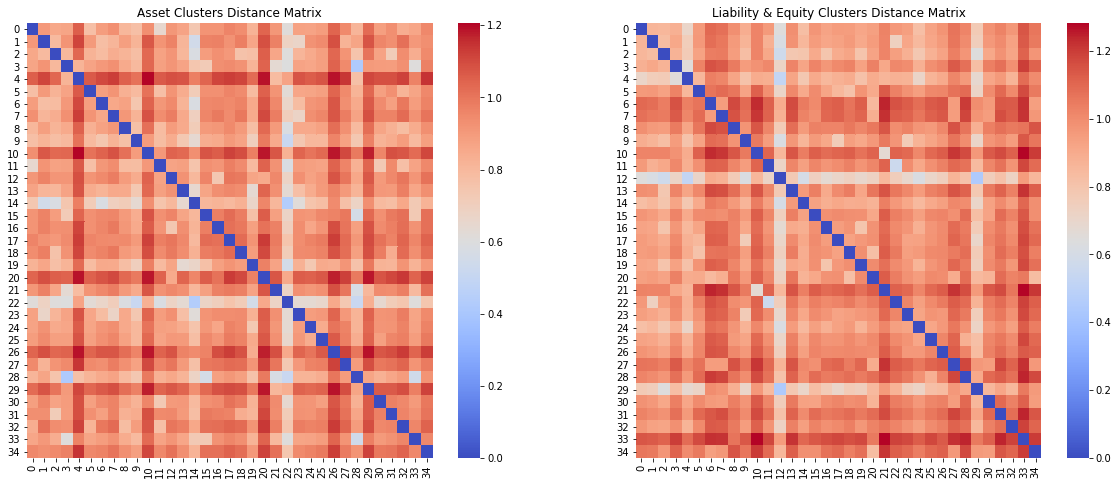

In [43]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
sns.heatmap(distance_matrix(assetCenters), cmap='coolwarm', ax=axes[0])
sns.heatmap(distance_matrix(liabilityCenters), cmap='coolwarm', ax=axes[1])
axes[0].set_title('Asset Clusters Distance Matrix')
axes[1].set_title('Liability & Equity Clusters Distance Matrix')
plt.show()

Clustering works to great effect with the vast majority of cases presented, but there still appears to be issues that persist when trying to divide the current dataset - namely more nuanced differences such as "Total Liabilites and Equity" and "Total Equity". I want to try grouping these and then clustering them again.

As exhbited, repeated clustering on a smaller subset of line items does not break it into expected groups. Rather, we arrive at similar breaks that we saw before when using a smaller KMeans cluster set. Hence, I will pursue the LDA as is, and see the label identificaition that follows.

## Latent Dirichlet Allocation with online variational Bayes algorithm
**A Topic Model for root-word detection from a list of similar strings** 

Our goal here is to determine whether using LDA decomposition is useful in determining label names for clustering classes

* The corpus is a collection of **D** documents, which will be a cluster with corresponding word groupings from KMeans
* A document is a sequence of **N** words, which corresponds to the sequence of characters of each word in the cluster
* There are **K** topics in the corpus, which will be one as we are looking to determine roots

In [24]:
def label_LDA(names, LDA_model):
    assert type(LDA_model).__name__ is 'LatentDirichletAllocation', 'Model restriction, only imposed LDA'
    
    print('Clustered names provided are:\n\n', names, '\n')
    labelNames = []
    
    # vectorize the text (string) data to be used by Latent Dirichlet Allocation algorithm
    text_mdl = TfidfVectorizer()
    vec_text = text_mdl.fit_transform(names)
    
    # feature names extracted from the TfidVectorizer
    feature_names = text_mdl.get_feature_names()
  
    # fit Laten Dirichlet Allocation model 
    mdl = LDA_model
    mdl.fit(vec_text)
    
    print()
    # print out label names determined from LDA
    for topic in mdl.components_:
        message = "Topic determined: "
        message += " ".join([feature_names[i]
                             # select the 5 most important feature names from largest to smallest order
                             for i in topic.argsort()[:-5 - 1:-1]])
        print(color.BOLD, message, color.END)
        labelNames.append(message)
    print()
    
    return labelNames

Continuing this current assesment of topic detection, we extend this to the entire subset of items computed from the clustering algorithm employed to group each of the asset/liability line items grouped before. **(Refer to KMeans Model for details on clustering)**


In [26]:
# creating names for liability line clusters
for i in range(df2.Labels.max()+1):
    print('Label', i)
    cluster_cells = df2[df2.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['10,000 shares issued and outstanding; $1 stated value' 'and outstanding'
 '200 shares authorized - NPV 100 shares issued & outstanding'
 '1,200 shares issued and outstanding' '220 shares issued and outstanding'
 '1,000 Shares, Issued and Outstanding'
 'and 100 shares issued and outstanding' '1,000 shares issued'
 '6,300,000 shares issued and outstanding'
 'authorized, 100 shares issued and outstanding'
 'Shares, Issued 301 Shares, Outstanding 0 Shares'
 '805,000 shares issued and outstanding'
 'shares authorized, 1,000 shares issued'
 'authorized, 277,284 shares issued and outstanding'
 'issued and outstanding, at stated value'
 'Issued And Outstanding - 100 Shares' 'and outstanding 1000 shares'
 'authorized, 414,836 shares issued and outstanding'
 'Issued and outstanding 1,000 shares' '10 shares issued and outstanding)'
 'issued and outstanding, 100 shares'
 '1,000 Shares Authorized, Issued and Outstanding'
 'shares issued and outstanding'
 '


 Topic determined: accrued liabilities expenses and other 


Label 6

Clustered names provided are:

 ['Total lia bilities' 'Accrued 401k contribution' 'B. Secured'
 'See accompanying notes to financial statement.' 'Affiliates'
 'Financial instruments ow ned' 'Accrued product costs'
 'D. Undue concentration' 'Commercial paper'
 'Accrued profit sharing contribution'
 'Corporate debt and collateralized mortgage obligations'
 'Liabilites: Current liabilities' 'Line of credit'
 'The accompanying notes are an integral part of these financial'
 'A. Clearance account' 'Commitments, contingencies and guarantees'
 '1 common share' '6. Options' 'Bank loans and overdrafts'
 'Accrued commissions and clearance charges' 'Corporate and other debt'
 'Supplemental Financial Information' 'Contributions'
 'Contractual commitments' "Morgan Stanley & Co. LLC member's equity"
 'Distributions' 'Fails to Receive' 'Stocks, warrants, and options'
 'Stocks, warrants and options' 'at market value:'
 '71,965 shar

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: yet sold purchased not securities 


Label 12

Clustered names provided are:

 ['17. Accounts payable, accrued liabilities, expenses and other'
 'Accounts Payable : Commissions'
 'Liabilities Accounts payable and accrued expenses'
 'Liabilities Accounts payable and accrued liabilities'
 'Accounts payable and other accrued liabilities'
 'Current liabilities Accounts payable and accrued expenses'
 'Accounts payable and Accrued Expenses Taxes Payable'
 'Accounts payable - commissions'
 'Accrued expenses and accounts payable Total Liabilities'
 'Accounts payable, accrued expenses and other liabilities'
 'accounts payable and accrued expenses' 'Accounts Payable'
 'Accounts payable - related party' 'Accounts payble and accrued expenses'
 'Accounts payable and accrued expenses'
 'Liabilities - Accounts payable and accrued expenses' 'Accounts payable'
 'Accou

iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: to broker payable dealer due 


Label 18

Clustered names provided are:

 ['Short-term borrowings (included $2,863 at fair value)'
 'Short-term borrowings' 'Short term borrowings (Note 6)'
 'Short-term borrowings (included $221 at fair value)'
 'Short term bonds and notes issued'
 'Unsecured short-term borrowings, including the current portion of unsecured long-term borrowings (includes $1,303,559 at fair value)'
 'Unsecured long-term borrowings (includes $347,904 at fair value)'
 'Borrowings' 'Liabilities: Short term borrowings (Note 6)'
 'Long-term debt (including $137 at fair value)'
 'Unsecured long-term borrowings (includes $146 at fair value)'
 'Unsecured short-term borrowings, including the current portion of unsecured long-term borrowings (includes $3 at fair value)'
 'Unsecured short-term borrowings, including the


 Topic determined: capital in paid additional partners 


Label 25

Clustered names provided are:

 ['Reverse conversion securities, at fair value'
 'Reverse conversion securities, at market value'
 'Deposits received for securities loaned'
 'Securities loaned (includes $4,964 at fair value)'
 'Securities loaned (includes fair value of $57)'
 'Securities loaned (includes $5,646 at fair value)'
 'Securities loaned (includes $14,642 at fair value)'
 'Securities loaned (includes $31,698 at fair value)'
 'Securities financing transactions: Securities sold under agreements to repurchase (includes securities at fair value of $80,267,928) Securities loaned (includes securities at fair value of $693,613)'
 'Securities financing transactions: Securities sold under agreements to repurchase (includes securities at fair value of $41,290,013) Securities loaned (includes securities at fair value of $155,881)'
 'Securities loaned (includes $7,483 at fair value)'
 'Securities loaned (includes $23,810

iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: note payable to notes stockholder 


Label 34

Clustered names provided are:

 ['TOTAL STOCKHOLDERS EQUITY' "Stockholders' equity"
 "Total liabilities and stockholders' equity" "Total stockholders' equity"
 "STOCKHOLDERS' EQUITY Capital Stock, at stated value,"
 "Total Liabilities and Stockholders' Equity"
 "Total Liabilities and stockholders' equity" "Total Stockholders' Equity"
 "TOTAL LIABILITIES & STOCKHOLDERS'"
 "TOTAL LIABILITIES AND STOCKHOLDERS' EQUITY"
 'TOTAL LIABILITIES AND STOCKHOLDERS EQUITY' "TOTAL STOCKHOLDERS' EQUITY"
 'Stockholders Equity'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iterati

In [28]:
df2.to_csv('liabilityLDA', index=False)

In [25]:
# creating names for assest line clusters
for i in range(df1.Labels.max()+1):
    print('Label', i)
    cluster_cells = df1[df1.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['Cash and securities segregated in compliance with federal and other regulations'
 'Cash and securities segregated pursuant to federal and other regulations'
 'Cash and securities deposited with clearing organizations or segregated under federal and other regulations or requirements (including securities at fair value of'
 'Cash segregated pursuant to federal and other regulations'
 'Cash, securities and securities purchased under agreements to resell segregated in compliance with federal and other regulations'
 'Cash segregated pursuant to federal regulations'
 'Cash and securities deposited with clearing organizations or segregated under federal and other regulations (securities at fair value of $16,654,789)'
 'Cash and securities deposited with clearing organizations or segregated under federal and other regulations (securities at fair value of $34,763,381)'
 'Cash and securities segregated pursuant to federal and other regulations (Note 3)'

iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: receivable broker from dealer clearing 


Label 6

Clustered names provided are:

 ['Furniture, equipment and leasehold improvements, (net of accumulated depreciation and amortization of $1,464,902)'
 'Furniture and fixtures (cost of $2,226,634, net of $752,753 accumulated depreciation)'
 'Furniture, equipment, leasehold improvements and software, net (includes'
 'Property, equipment and leasehold improvements, at cost (less accumulated depreciation and amortization of $180,979) Other assets'
 'Property, equipment and leasehold improvements, net of accumulated depreciation and amortization of $208'
 'Property, equipment and leasehold improvements, at cost (less accumulated depreciation and amortization of $207,276) Other assets'
 'NET BUILDING, FURNITURE AND FIXTURES'
 'Furniture and equipment, net of accumulated depreciation of $105,572'
 'Property, equipment and leasehold impro

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: net of equipment property and 


Label 9

Clustered names provided are:

 ['Cash and securities segregated for regulatory and other purposes (includes $63,394 at fair value)'
 'Cash and securities segregated for benefit of customers (includes securities at fair value of $7,901)'
 'Cash and securities segregated for benefit of customers'
 'Cash and securities segregated for regulatory and other purposes (includes $81,619,815 at fair value)'
 'Cash and securities segregated for benefit of customers (includes securities at fair value of $7,862)'
 'Cash and securities segregated for benefit of customers (includes securities at fair value of $7,338)'
 'Cash and securities segregated fo

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: payable loan advances to employee 


Label 14

Clustered names provided are:

 ['Receivable from noncustomer' 'Commission receivable'
 'Receivable from customers, net'
 'Commissions receivable - net of reserves of $414'
 'Accrued interest and dividends receivable' 'Receivable from brokers'
 'Fees receivable' 'Receivable from Parent, net' 'Interest receivable'
 'Accrued interest receivable' 'Receivable from affiliates (Note 6)'
 'Commissions and fees receivable' 'Loan Receivable' 'Dividend receivable'
 'COMMISSIONS RECEIVABLE' 'Receivable from Others'
 'Insurance commissions receivable' 'Notes receivable (notes 3 and 4)'
 'Commissions Receivable - Clearing Corp.'
 'Notes receivable - related parties' 'Receivable from Non-Customer'
 'Loan Receivable - Employees' 'Investment advisory fees receivable'
 'Commissions receivable' 'Receivable from related par

 'Securities received as collateral, at fair value (included assets pledged of $1,912)'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: as collateral securities received pledged 


Label 21

Clustered names provided are:

 ['U.S. government agency securities owned, at market'
 'U.S. Government and agency obligations pledged as collateral'
 'U.S. government and government agency securities'
 'U.S. government and agency securities'
 'U.S. Government obligations pledged as collateral'
 'U.S. Government and agency obligations'
 'Non-U.S. government and government agency securities'
 'U.S. government and federal agency'
 'U.S. Treasury and federal agency securities'
 'Foreign government securities' 'Non-U.S. government and govern

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: securities agreements under to value 


Label 26

Clustered names provided are:

 ['Deposits with and receivables from clearing broker' 'Time deposits'
 'Deposits with clearing organization' 'Deposits - clearing organizations'
 'Deposits received for securities loaned'
 'Deposits with clearing organizations and others' 'Deposits'
 'Deposits with exchanges and other segregated cash'
 'Deposits with clearing organizations' 'Deposits at clearing broker'
 'Clearing deposits'
 'Deposits paid for securities borrowed (including $50,553 at fair value)'
 'Deposits paid for securities borrowed (including $43,180 at fair value)'
 'Deposits paid for securities borrowed' 'Clearing firm deposits'
 'Deposits with clearing brokers' 'Deposits at clearing brokers'
 'Security deposits' 'Deposits with clearing organization (cash)'
 'Deposits with clearing firms'
 'Other 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: of amortization and depreciation accumulated 


Label 32

Clustered names provided are:

 ['Federal Income Tax Payable' 'Income tax refund receivable'
 'Income tax receivable' 'Income taxes recoverable'
 'CURRENT LIABILITY, Income tax payable' 'Deferred income taxes'
 'Investment income receivable' 'Federal income taxes receivable'
 'Prepaid federal income tax' 'Deferred income taxes, net'
 'Increase in income taxes recoverable' 'Deferred Taxes - Federal'
 'Refundable Income Tax State' 'Prepaid State Income Tax' 'Net Income'
 'Prepaid federal and state taxes' 'Accrued income tax'
 'State Income Taxes Payable' 'State and Local Income Tax Receivable'
 'Refundable income taxes' 'Prep

In [29]:
df1.to_csv('assetLDA', index=False)

In [ ]:
'Total current assets'
'TOTAL CURRENT ASSETS'
'Total Current Assets'

## Supervised Learning of Label Names
**Construct a classification model to match user defined categories to established balance sheet items**

In [31]:
# manualy assigning label names to corresponding cluster labels according to personal bias
assetlabelReplace = {
    0: "Cash and cash equivalents", 
    1: "Accumulated depreciation and amortization", 
    2: "Receivables from customers and counterparties",
    3: "Financial instruments owned, at fair value", 
    4: "Property, plant and equipment",
    5: "Receivable from broker-dealers",
    6: "Property, plant and equipment",
    7: "Other assets",
    8: "Property, plant and equipment",
    9: "Cash and securities segregated for benefit of customers",
    10: "Financial instruments owned, at fair value",
    11: "Due from counterparties",
    12: "Receivable from broker-dealers",
    13: "Loan advances to employee",
    14: 'Other receivables',
    15: "Deferred tax asset",
    16: "Financial instruments owned, at fair value",
    17: "Escrow account balances",
    18: "Exchange memberships",
    19: "Cash and cash equivalents",
    20: "Securities received as collateral",
    21: "U.S. government and government agency",
    22: "Financial instruments owned, at fair value",
    23: "Prepaid expenses and other assets",
    24: "Other assets", 
    25: "Reverse Repurchase Argreements (reverse-repo)",
    26: "Deposits with clearing organizations",
    27: "Deposits with clearing organizations",
    28: "Account receivable",
    29: "Total assets", 
    30: "Financial instruments owned, at fair value",
    31: "Accumulated depreciation and amortization", 
    32: "Other assets",
    33: "Fixed assets",
    34: "Other assets"
}

In [32]:
# first order change for cluster items
df1['classification'] = df1['Labels'].replace(assetlabelReplace)

In [36]:
# to deal with the overlaping "Total" components we filter these each by line item
assetlineReplace = {
    'Financial instruments sold under agreements to repurchase, at fair value': 'Repurchase Argreements (repo)',
    'Financial instruments sold, but not yet purchased, at fair value': "Securities sold short",
    'Note 4. Financial Instruments Owned and Financial Instruments Sold, But Not Yet Purchased': "Securities sold short",
    'Financial instruments sold, not yet purchased': "Securities sold short",
    'Financial instruments sold, not yet purchased,': "Securities sold short",
    'Financial instruments sold, not yet purchased, and': "Securities sold short",
    'Total financial instruments sold, not yet purchased, at fair value': "Securities sold short",
    'Less: Accumulated Depreciation':  "Accumulated depreciation and amortization",  
    'Accumulated Depreciation': "Accumulated depreciation and amortization", 
    'depreciation of $68,679)': "Accumulated depreciation and amortization", 
    'depreciation of $14,370': "Accumulated depreciation and amortization", 
    'depreciation of $7,591': "Accumulated depreciation and amortization", 
    'Accumulated depreciation': "Accumulated depreciation and amortization",
    'Accumulated Depreciation of $37,298': "Accumulated depreciation and amortization", 
    'Less Accumulated Depreciation': "Accumulated depreciation and amortization", 
    'Accumulated Depreciation of $37,138': "Accumulated depreciation and amortization", 
    'depreciation of $57,062': "Accumulated depreciation and amortization", 
    'Less: Accumulated depreciation': "Accumulated depreciation and amortization", 
    'accumulated depreciation of $190,428': "Accumulated depreciation and amortization", 
    'accumulated depreciation': "Accumulated depreciation and amortization", 
    'depreciation of $145,900)': "Accumulated depreciation and amortization", 
    'depreciation of $82,129)': "Accumulated depreciation and amortization", 
    'Less accumulated depreciation': "Accumulated depreciation and amortization", 
    'Receivables - other': 'Other receivables',
    'Other Receivables': 'Other receivables',
    'Accrued interest and dividend receivables': 'Other receivables', 
    'Trade receivables': 'Other receivables', 
    'Employee receivables': 'Other receivables', 
    'Customers': 'Other receivables', 
    'Branch receivables': 'Other receivables', 
    'Miscellaneous receivables': 'Other receivables',
    'Other receivables': 'Other receivables',
    'Other Non Current Receivables': 'Other receivables', 
    'Receivables from affiliates (Note 6)': 'Other receivables', 
    'Receivables:': 'Other receivables', 
    'Receivables-other': 'Other receivables',
    'Receivables': 'Other receivables', 
    'Receivables-othe:': 'Other receivables',
    'Accounts payable': 'Accounts payable', 
    'Accounts payable and Accrued Expenses': 'Accounts payable', 
    'Accounts Payable': 'Accounts payable', 
    'Taxes Payable': 'Accounts payable', 
    'Payable to broker Dealers, exchange': 'Accounts payable',  
    'Payroll taxes payable': 'Accounts payable', 
    'Payable to Affiliate': 'Accounts payable',  
    'State and Local Tax Payable': 'Accounts payable',
    'Accounts Payable - Commissions': 'Accounts payable',  
    'Payroll Taxes Payable': 'Accounts payable', 
    'Payable to affiliates' : 'Accounts payable', 
    'Clearing charges payable': 'Accounts payable', 
    'Dividends Payable': 'Accounts payable', 
    'Accounts payable and accrued expenses': 'Accounts payable', 
    'Payable to affiliate': 'Accounts payable', 
    'Payable to clearing broker': 'Accounts payable', 
    'Payable to Related Party': 'Accounts payable', 
    'Investments, at fair value': "Financial instruments owned, at fair value",
    'Investments in Securities, at value (cost $3,300)': "Financial instruments owned, at fair value", 
    'Money market investments': "Financial instruments owned, at fair value", 
    'Investments, at market value': "Financial instruments owned, at fair value",
    'Commercial paper and money market funds': "Financial instruments owned, at fair value",
    'Money market instruments': "Financial instruments owned, at fair value", 
    'Cash & Liquid Money Market Funds': "Financial instruments owned, at fair value",
    'Investments, at cost': "Financial instruments owned, at fair value",
    'Other Receivable': 'Other receivables',
    'Receivable - Other': 'Other receivables',
    'Securities pledged under collateral agreements (Note 4)': "Repurchase Argreements (repo)",
    'Securities loaned or sold under agreements to repurchase (including $8,810 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (including $70,440 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes S36,781 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (includes $347,715 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $12,694 at fair value)': "Repurchase Argreements (repo)",
    'purchased agreements Securities borrowed (includes securities at fair value of $26,492)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $61,182 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase, at fair value': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (includes $848,785 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $14,820 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $79,312,735 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (including $71,901 at fair value)': "Repurchase Argreements (repo)",
    'Receivable under securities borrowing arrangements (includes $10,556 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $14,092 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $82,144 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $62,191 at fair value)': "Repurchase Argreements (repo)",
    'Securities loaned or sold under agreements to repurchase (including $13,083 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $74,019 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $32,849 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes fair value of $15,602)': "Repurchase Argreements (repo)",
    'Securities loaned (includes $28,978 at fair value)': "Repurchase Argreements (repo)",
    'Securities loaned or sold under agreements to repurchase (including $2,562 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $24,353 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $43,452 at fair value)': "Repurchase Argreements (repo)",
    'Securities loaned (includes $6 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $23,356 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (includes $363,715 at fair value)': "Repurchase Argreements (repo)",
    'Securities loaned and sold under agreements to repurchase (including $5,207 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes fair value of $23,345)': "Repurchase Argreements (repo)",
    'Receivable under securities borrowing arrangements (includes $33,075 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase': "Repurchase Argreements (repo)",
    'Securities borrowed (includes securities at fair value of $41,128,727)': "Repurchase Argreements (repo)",
    'TOTAL OTHER ASSETS': 'Other assets', 
    'Total Other Assets': 'Other assets', 
    'Total fixed assets': 'Other assets', 
    '1. Total Ownership Equity': 'Other assets', 
    'Total non-current assets': 'Other assets', 
    'Total other assets': 'Other assets', 
    'Total current assets': 'Total current assets',
    'TOTAL CURRENT ASSETS': 'Total current assets',
    'Total Current Assets': 'Total current assets',
}

In [37]:
# second order change for liability line items, retaining changes from first cluster labels
# notice we retain all line items that were not altered by line-replacement
upperHalf = df1[~np.isin(df1.LineItems, list(assetlineReplace.keys()))]

# now alter the classification labels to fit
lowerHalf = df1[np.isin(df1.LineItems, list(assetlineReplace.keys()))]
lowerHalf['classification'] = lowerHalf['LineItems'].replace(assetlineReplace)

In [38]:
# concat seperate components vertically, this is our completed dataset
assetLearning = pd.concat([upperHalf, lowerHalf])[['LineItems', 'classification']]

In [39]:
assetLearning

,LineItems,classification
0,Net cash provided by (used for) investing acti...,Other assets
1,Due from FCM,Due from counterparties
2,accumulated depreciation and amortization of $...,Accumulated depreciation and amortization
4,EMPLOYEE LOANS,Other assets
5,Cash and securities segregated in compliance w...,Cash and cash equivalents
...,...,...
1384,Less accumulated depreciation,Accumulated depreciation and amortization
1385,Receivables-othe:,Other receivables
1397,"Total financial instruments sold, not yet purc...",Securities sold short
1411,Securities borrowed (includes securities at fa...,Repurchase Argreements (repo)


In [40]:
assetLearning.to_csv('assetML.csv', index=False)

In [74]:
# manualy assigning label names to corresponding cluster labels according to personal bias
liabilitylabelReplace = {
    0: "Total shareholder's equity", 
    1: "Common stock, par value", 
    2: "Other liabilites",
    3: "Other liabilites",
    4: "Short-term & Long-term borrowing",
    5: "Repurchase Argreements (repo)",
    6: "Securities sold short",
    7: "Total liabilities and shareholder's equity",
    8: "Income tax payable",
    9: "Lease Liability",
    10: "Accrued liabilities",
    11: "Retained (Accumulated) earnings",
    12: "Accounts Payable",
    13: "Other liabilites",
    14: "Total liabilities and shareholder's equity",
    15: "Total liabilities and shareholder's equity",
    16: "Additional Paid-in capital",
    17: "Total liabilities and shareholder's equity",
    18: "Due to third party affiliates",
    19: "Common stock, par value", 
    20: "Other liabilites",
    21: "Subordinated liabilities",
    22: "Treasury stock",
    23: "Common stock, par value",
    24: "Government and agency securities obligations", 
    25: "Payable to Broker/Dealers",
    26: "Accounts payable",
    27: "Other liabilites",
    28: "Other liabilites",
    29: "Total liabilites", 
    30: "Payable to Broker/Dealers",
    31: "Accounts payable",
    32: 'Deferred tax liability',
    33: 'Securities loaned', 
    34: "Other liabilites"
}

In [75]:
# first order change for cluster items
df2['classification'] = df2['Labels'].replace(liabilitylabelReplace)

In [78]:
# to deal with the overlaping "Total" components we filter these each by line item
liabilitylineReplace = {
    "Loan payable to member": "Accounts Payable", 
    "Payable to Member": "Accounts Payable", 
    "Member's distribution payable": "Accounts Payable",
    "Total libilities and stocklholders' equity": "Total liabilities and shareholder's equity",
    "Total liabilities and member's capital": "Total liabilities and shareholder's equity",
    "TOTAL LIABILITIES AND MEMBER'S EQUITY": "Total liabilities and shareholder's equity",
    'Due to member': 'Other liabilites',
    "TOTAL LIABILITIES AND MEMBER'S CAPITAL": "Total liabilities and shareholder's equity",
    "Member's interest": "Other liabilites",
    "Member's contributions": "Other liabilites",
    "TOTAL LIABILITIES & MEMBER'S EQUITY": "Total liabilities and shareholder's equity",
    "Stockholder's equity (Note 13)": "Total shareholder's equity",
    "Members' equity": "Total shareholder's equity",
    "Total Stockholder' Equity": "Total shareholder's equity",
    "STOCKHOLDER'S EQUITY": "Total shareholder's equity",
    "Stockholder's equity.": "Total shareholder's equity",
    "Total Stockholder's Equity": "Total shareholder's equity",
    "MEMBERS' EQUITY": "Total shareholder's equity",
    "Members' Equity": "Total shareholder's equity",
    "Total Members' Equity": "Total shareholder's equity", 
    "Total stockholder's equity": "Total shareholder's equity",
    "Total MEMBERS' EQUITY": "Total shareholder's equity",
    'Total stockholder equity': "Total shareholder's equity",
    "Stockholder's equity:": "Total shareholder's equity",
    "Stockholder's equity": "Total shareholder's equity", 
    "Total members' equity": "Total shareholder's equity", 
    'Equity securities': "Other equity",
    'Payables to Parent and affiliated companies': "Accounts Payable", 
    'Payable to Parent, net': "Accounts Payable", 
    "TOTAL STOCKHOLDERS' EQUITY": "Total shareholder's equity",
    "Stockholders' equity (Note 15)": "Total shareholder's equity",
    "Total stockholders' equity": "Total shareholder's equity",
    'Stockholders Equity': "Total shareholder's equity",
    "Total Stockholders' equity:": "Total shareholder's equity",
    "STOCKHOLDERS' EQUITY Capital Stock, at stated value,": "Total shareholder's equity",
    "Total Stockholders' Equity": "Total shareholder's equity",
    "Stockholders' equity": "Total shareholder's equity",
    'TOTAL STOCKHOLDERS EQUITY': "Total shareholder's equity",
    "Total Shareholders' Equity": "Total shareholder's equity",
    'Liabilities Due to shareholders': "Other liabilites",
    "Total Shareholders' Deficit": "Total shareholder's equity",
    "Total shareholders' equity": "Total shareholder's equity",
    'Total Shareholders Equity': "Total shareholder's equity",
    "TOTAL SHAREHOLDERS' EQUITY": "Total shareholder's equity",
    "Total shareholder's equity": "Total shareholder's equity",
    'Total shareholder equity': "Total shareholder's equity",
    "Liabilities and Shareholder's Equity Accrued expenses": "Accrued liabilities",
    "Shareholder's equity": "Total shareholder's equity",
    "Total Shareholder' S Equity": "Total shareholder's equity",
    "TOTAL SHAREHOLDER'S EQUITY": "Total shareholder's equity",
    "Total Shareholder' Equity (Deficit)": "Total shareholder's equity",
    "Total Shareholder' Equity": "Total shareholder's equity",
    "Total Shareholder's Equity (Deficit)": "Total shareholder's equity",
    'Preferred Stock': "Common stock, par value",
    'Series A preferred stock': "Common stock, par value", 
    "Members' capital": "Total shareholder's equity",
    'Current liabilities': "Current liabilites",
    'Total current liabilities': "Current liabilites",
    'Total Assets': 'Other liabilites', 
    "TOTAL LIABILITIES AND MEMBERS' CAPITAL": "Total liabilities and shareholder's equity",
    'Total Current Liabilities': "Current liabilites",
    'Total': "Total liabilities and shareholder's equity",
    'Liabilites: Current liabilities': "Current liabilites",
    "Total liabilities and members' capital": "Total liabilities and shareholder's equity",
    'TOTAL CURRENT LIABILITIES': "Current liabilites",
    'Payables to customers (includes $983 at fair value)': "Accounts Payable", 
    'Payables to customers (includes $1,013 at fair value)': "Accounts Payable",
    'Payables to customers (includes $987 at fair value)': "Accounts Payable",
    'Borrowings at fair value': "Short-term & Long-term borrowing",
    'Borrowings (includes $574 at fair value)': "Short-term & Long-term borrowing",
    'Liabilities (note 3)': "Total liabilites", 
    'Payables:': 'Accounts Payable',
    'Interest payable (Note 5)': 'Accounts Payable',
    'Note Payable (Note 6)': 'Accounts Payable',
    'Note payable': 'Accounts Payable',
    'Payables to affiliates (Note 6)': "Accounts Payable",
    'Payables to customers': "Accounts Payable",
    'Notes payable (Note 7)': "Accounts Payable",
    'Payables to brokerage customers': "Payable to Broker/Dealers",
    'Payables to affiliates (Note 7)': "Accounts Payable",
    'Note Payable to Stockholder - Nonsubordinated': "Accounts Payable",
    'Payables to affiliated companies': "Accounts Payable",
    'Notes payable (Note 6)': "Accounts Payable",
    'NOTE PAYABLE TO STOCKHOLDER': "Accounts Payable",
    'Payables to affiliates': "Accounts Payable",
    'Payables to customers and counterparties': "Accounts Payable",
    'Borrowings from affiliates': "Short-term & Long-term borrowing",
    "Members' Capital (Note 7)": "Total shareholder's equity",
    'Branch payables': "Accounts Payable",
    'Payable to affiliates (Note 6)': "Accounts Payable",
    'Payable to affiliates': "Accounts Payable"
}

In [79]:
# second order change for liability line items, retaining changes from first cluster labels
# notice we retain all line items that were not altered by line-replacement
upperHalf = df2[~np.isin(df2.LineItems, list(liabilitylineReplace.keys()))]

# now alter the classification labels to fit
lowerHalf = df2[np.isin(df2.LineItems, list(liabilitylineReplace.keys()))]
lowerHalf['classification'] = lowerHalf['LineItems'].replace(liabilitylineReplace)

In [80]:
# concat seperate components vertically, this is our completed dataset
liabileLearning = pd.concat([upperHalf, lowerHalf])[['LineItems', 'classification']]

In [81]:
liabileLearning

,LineItems,classification
0,Lease purchase payable to Fleet Leasing,Lease Liability
1,Subordinated borrowings,Subordinated liabilities
2,"Securities loaned (includes $31,698 at fair va...",Securities loaned
3,Long term borrowings at fair value (relates to...,Other liabilites
4,Borrowings from Parent,Other liabilites
...,...,...
919,Total members' equity,Total shareholder's equity
934,TOTAL SHAREHOLDERS' EQUITY,Total shareholder's equity
940,TOTAL CURRENT LIABILITIES,Current liabilites
944,TOTAL LIABILITIES & MEMBER'S EQUITY,Total liabilities and shareholder's equity


In [82]:
liabileLearning.to_csv('liabilityML.csv', index=False)

## Classification Model Training 
**We implement a Linear SVC model, with a hashing vectorizer to convert our string data into numerical measures**

In [324]:
def cls_sec(X, y, vectorizer, classification, cvSplits:int=5):
    
    # cross-validating engine used for CV score
    cv = StratifiedKFold(n_splits=cvSplits, shuffle=True, random_state=42)
    
    # compute the cross-validation for a X and Y components
    cv_score = cross_val_score(clf, vectorizer.fit_transform(X.values.flatten()), y, cv=cv, 
                               scoring='f1_macro', verbose=0)
    
    # split dependent and independent variables into training and testing windows (random split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=1)
    
    # vectorizes the text via Tfid to be used in classification implementation 
    x_train = vectorizer.fit_transform(X_train.values.flatten())
    x_test = vectorizer.fit_transform(X_test.values.flatten())
    
    # intantiate the classification model and fit data
    mdl = classification
    mdl.fit(x_train, y_train)
    
    # predict target classes based on classification model
    y_pred = mdl.predict(x_test)
    
    # compute percision score, representing the true positive count
    score = round(precision_score(y_test, y_pred, average='micro'), 4) * 100
    print("\nPercision score using a micro average is {s}%".format(s=score))
    print('Cross-validation measures using {} splits are'.format(cvSplits))
    print(cv_score)
    print('A micro average calculates metrics globally by counting the total true positives, false negatives and false positives.')
    
    return mdl, X_test, y_test, y_pred, cv_score

In [249]:
assetML = pd.read_csv('assetML.csv')

In [250]:
liabilityML = pd.read_csv('liabilityML.csv')

In [251]:
# break subset of line items and classification, for classification algorithm 
X1 = assetML[['LineItems']]
y1 = assetML[['classification']]

X2 = liabilityML[['LineItems']]
y2 = liabilityML[['classification']]

In [325]:
mdl1, xtest1, testcase1, pred1, cv1 = cls_sec(X1, y1, HashingVectorizer(n_features=500, strip_accents='ascii'), 
                                              LinearSVC(penalty='l2', loss='squared_hinge', multi_class='crammer_singer',
                                                        verbose=1, random_state=1))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
Percision score using a micro average is 94.83%
Cross-validation measures using 5 splits are
[0.8889511  0.95042823 0.90364814 0.92024718 0.86152376]
A micro average calculates metrics globally by counting the total true positives, false negatives and false positives.


In [326]:
mdl2, xtest2, testcase2, pred2, cv2 = cls_sec(X2, y2, HashingVectorizer(n_features=500, strip_accents='ascii'), 
                                              LinearSVC(penalty='l2', loss='squared_hinge', multi_class='crammer_singer',
                                                        verbose=1, random_state=1))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
Percision score using a micro average is 88.38000000000001%
Cross-validation measures using 5 splits are
[0.90793989 0.87299215 0.9330032  0.9024202  0.86580025]
A micro average calculates metrics globally by counting the total true positives, false negatives and false positives.


In [314]:
# confusion matrix reflecting the accuracy of prediction across the each label
# each row shows the count of each corresponding label column wise, should have the columns the most populated
cmat1 = pd.DataFrame(confusion_matrix(testcase1, pred1, normalize=None), 
                     columns=np.unique(testcase1), index=np.unique(testcase1))
cmat2 = pd.DataFrame(confusion_matrix(testcase2, pred2, normalize=None), 
                     columns=np.unique(testcase2), index=np.unique(testcase2))

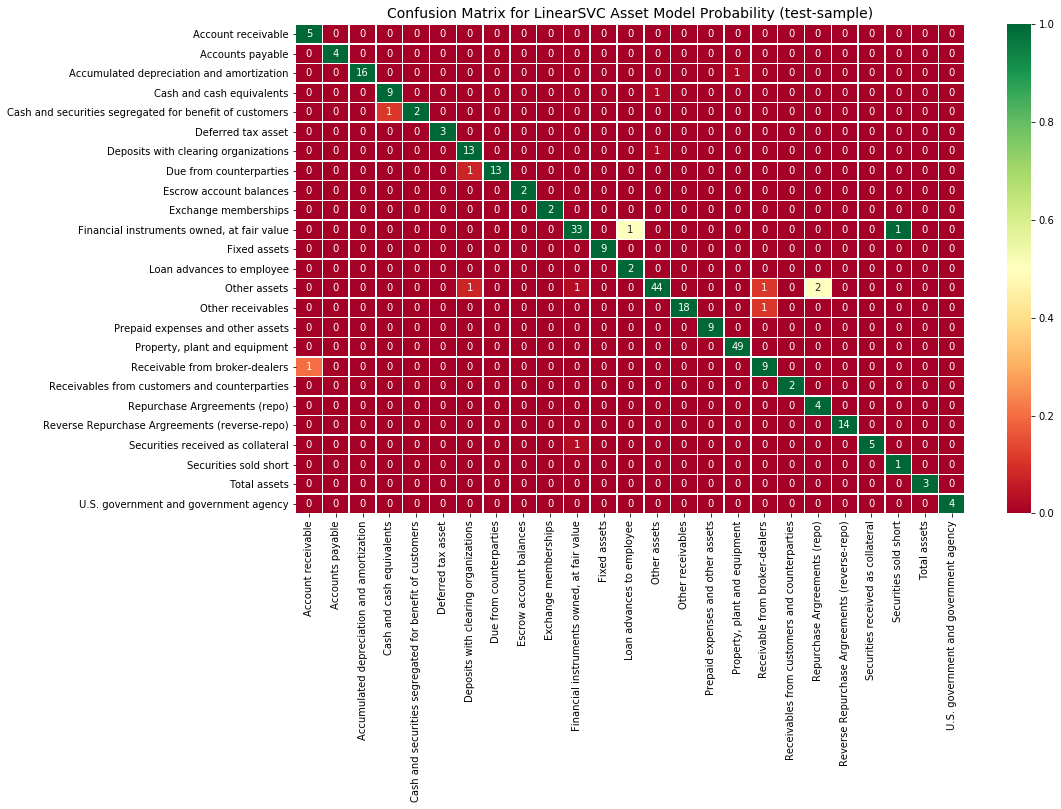

In [317]:
plt.figure(figsize=(15, 9))
plt.title('Confusion Matrix for LinearSVC Asset Model Probability (test-sample)', fontsize=14)
scaled_df = (cmat1 - cmat1.min(axis=0)) / (cmat1.max(axis=0) - cmat1.min(axis=0))
sns.heatmap(scaled_df, annot=cmat1, linewidths=.5, cmap="RdYlGn")
plt.show()

In [302]:
label = 'Account receivable'
print('Predictions from the model are')
print(pred1[pred1 == label])
print()
print('Determined labels for the line items')
print(testcase1[pred1 == label].classification.values)
print()
print('Original labels used to predict from')
print(xtest1[pred1 == label].values)

Predictions from the model are
['Account receivable' 'Account receivable' 'Account receivable'
 'Account receivable' 'Account receivable' 'Account receivable']

Determined labels for the line items
['Account receivable' 'Account receivable' 'Account receivable'
 'Account receivable' 'Account receivable'
 'Receivable from broker-dealers']

Original labels used to predict from
[['Accounts receivable - employees']
 ['Company clearing accounts']
 ['ACCOUNTS RECEIVABLE - Net of allowance for doubtful accounts of $574']
 ['Accounts receivable - related parties']
 ['ACCOUNTS RECEIVABLE - Net of allowance for doubtful accounts of $26,224']
 ['Accounts Receivable from broker-dealer']]


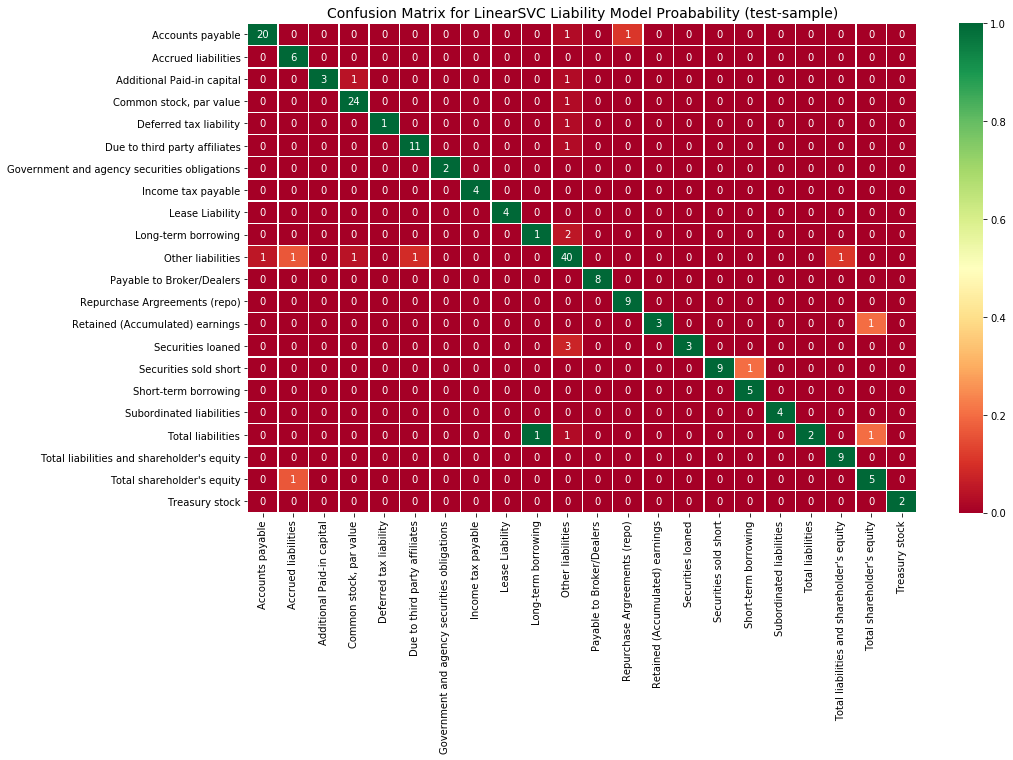

In [318]:
plt.figure(figsize=(15, 9))
plt.title('Confusion Matrix for LinearSVC Liability Model Proabability (test-sample)', fontsize=14)
scaled_df = (cmat2 - cmat2.min(axis=0)) / (cmat2.max(axis=0) - cmat2.min(axis=0))
sns.heatmap(scaled_df, annot=cmat2, linewidths=.5, cmap="RdYlGn")
plt.show()

In [307]:
label = 'Other liabilities'
print('Predictions from the model are')
print(pred2[pred2 == label])
print()
print('Determined labels for the line items')
print(testcase2[pred2 == label].classification.values)
print()
print('Original labels used to predict from')
print(xtest2[pred2 == label].values)

Predictions from the model are
['Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabilities'
 'Other liabilities' 'Other liabilities' 'Other liabil

### Out-of-sample Label Predictions

In [112]:
# transposed tuple matching for array vectors of each 
np.array((outAssets, mdl1.predict(HashingVectorizer(n_features=500).fit_transform(outAssets)))).T[:10]

array([['Accrued interest', 'Other assets'],
       ['Brokers-dealers and clearing organizations',
        'Receivable from broker-dealers'],
       ['Accounts receivable - affiliate (Note 3)', 'Account receivable'],
       ['Fixed assets, at cost (net of accumulated depreciation of $194,905)',
        'Fixed assets'],
       ['Cash - restricted', 'Cash and cash equivalents'],
       ['Customers and counterparties (includes $268 at fair value)',
        'Receivables from customers and counterparties'],
       ['Securities owned, pledged to counterparties, at fair value',
        'Financial instruments owned, at fair value'],
       ['Investments in affiliates', 'Other assets'],
       ['Cash, restricted', 'Cash and cash equivalents'],
       ['Broker loans receivable, net of current portion',
        'Other receivables']], dtype=object)

In [110]:
np.array((outLiability, mdl2.predict(HashingVectorizer(n_features=500).fit_transform(outLiability)))).T[:10]

array([['Commitments, contingencies and guarantees: Subordinated indebtedness',
        'Subordinated liabilities'],
       ['Due to affiliate (Note 5)', 'Due to third party affiliates'],
       ['Note 16. Related parties', 'Other liabilites'],
       ['Assets', 'Other liabilites'],
       ['Loans', 'Other liabilites'],
       ['Options', 'Other liabilites'],
       ['Management fee payable to related party', 'Accounts payable'],
       ['10.000 shares issued and outstanding',
        'Common stock, par value'],
       ['Fail to Receive', 'Other liabilites'],
       ['Accrued payroll and related liabilities', 'Accrued liabilities']],
      dtype=object)

In [120]:
# for storing model persistence 
# https://scikit-learn.org/stable/modules/model_persistence.html

# cross-validation for out-of-sample testing
# https://scikit-learn.org/stable/modules/cross_validation.html

## Consolidating Clusters to Structured Database
**Structured convergece for Unstructured data labels**

In [133]:
# journal of physics A, Journal Stat. Physics
def structured_data(unstructured_df:pd.DataFrame, cluster_df:pd.DataFrame, label_names:np.array) -> pd.DataFrame:
    """
    Constructs a structured dataset from an unstructured column set
    
    :param: unstructured_df (type pandas.DataFrame)
        unstuructured pandas dataframe with loose column construction 
    :param: cluster_df (type pandas.DataFrame)
        a pandas dataframe of clustered labels and corresponding line items
    :param: (type numpy array)
        all corresponding cluster labels cirresponding with 'cluster_df' parameter
        
    :return: (type pandas DataFrame)
    """
    
    structured_df = pd.DataFrame()
    
    # assume that the there exists columns 'CIK' and 'Year' for unstructured data
    structured_df = unstructured_df[['CIK', 'Year']]
    
    for label in label_names:
        data = cluster_df[cluster_df['Labels'] == label]['LineItems']     # filter by corresponding cluster
        
        # sum all columns, across row and map to structured dataframe
        structured_df[label] = unstructured_df[data.values].sum(axis=1)
        
    return structured_df

In [134]:
structured_data(assets, df, df['Labels'].unique())

,CIK,Year,3,2,4,6,11,14,10,0,9,13,7,5,1,12,8
0,1000147,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74600.0,0.0,0.0
1,1000147,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75800.0,0.0,0.0
2,1000147,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76500.0,0.0,0.0
3,1000147,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000147,2006,36301.0,0.0,332085.0,0.0,0.0,0.0,15788.0,0.0,2005.0,0.0,0.0,42132.0,253652.0,0.0,395.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1000320,2009,0.0,0.0,0.0,0.0,13000.0,0.0,0.0,653311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,1000320,2010,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,88052.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,1000320,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,1000320,2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
